## Re-examine SF_Uncert metric in DDF regarding season length

In [1]:
# development code
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

In [3]:
# add the path the scripts
sys.path.insert(0, "../scripts/")

In [4]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf as maf
from rubin_sim.maf.utils import m52snr

# footprint utils
from rubin_sim.scheduler.utils import footprints

# import convenience functions
from opsimUtils import *

# import custom stacker/metrics from script
from agnstructure import *

# print version
import rubin_sim

rubin_sim.__version__

'0.10.1.dev64+gc32f68b'

### 1. Pull rolling opsims to evaluate 

In [5]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values

# pull roll runs
fam = ["ddf season length"]
baseline_run = families.loc["ddf season length", "reference"]
roll_runs = np.concatenate([[baseline_run], families.explode("run").loc[fam, "run"]])
roll_runs

array(['baseline_v2.1_10yrs', 'ddf_season_length_slf0.10_v2.1_10yrs',
       'ddf_season_length_slf0.15_v2.1_10yrs',
       'ddf_season_length_slf0.20_v2.1_10yrs',
       'ddf_season_length_slf0.25_v2.1_10yrs',
       'ddf_season_length_slf0.30_v2.1_10yrs',
       'ddf_season_length_slf0.35_v2.1_10yrs'], dtype=object)

### 2. Test SF Uncert on the baseline

In [8]:
dbDir = rubin_sim.data.get_data_dir()
outDir = "/home/jovyan/mount/ResearchData/MAFOutput/Temp/ResultsDb"
metricDataPath = "/home/jovyan/mount/ResearchData/MAFOutput/Temp/MetricData"

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [9]:
# create dict for storing dbs
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=roll_runs)

In [12]:
ddfFields = ['COSMOS', 'XMM-LSS', 'ELAISS1', 'ECDFS', 'EDFS']

In [66]:
# custom sf bins
nbin = 20
mybins = np.logspace(0, np.log10(3650), nbin+1)
myweights = np.full(nbin, 1/nbin)

# metric + constraint
sfuncert = SFUncertMetric(mag=23.94, 
                          bins=mybins, weight=myweights, 
                          snr_cut=0)
constraint = 'filter = "g"'

# custom slicer
nside = 128
radius = 1.8
hp_mask = ddf_hp_mask(ddfFields[0], radius, nside)
slicer = slicers.HealpixSubsetSlicer(nside, np.where(hp_mask == 1)[0])
slicer.slicerName = 'HealpixSlicer'  # hack maf

# create bundle
sfmb = metricBundles.MetricBundle(sfuncert, slicer, constraint)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [67]:
bdict = {0: sfmb}

In [71]:
run = 'ddf_season_length_slf0.35_v2.1_10yrs'
gp = metricBundles.MetricBundleGroup(bdict, opSimDbs[run], 
                                     outDir=outDir, 
                                     resultsDb=resultDbs[run])
gp.runAll()

Querying table None with constraint filter = "g" for columns ['fiveSigmaDepth', 'rotSkyPos', 'fieldDec', 'filter', 'observationStartMJD', 'fieldRA']
Found 229466 visits
Running:  [0]


/opt/conda/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [72]:
mask = sfmb.metricValues.mask
data = sfmb.metricValues.data[~mask]

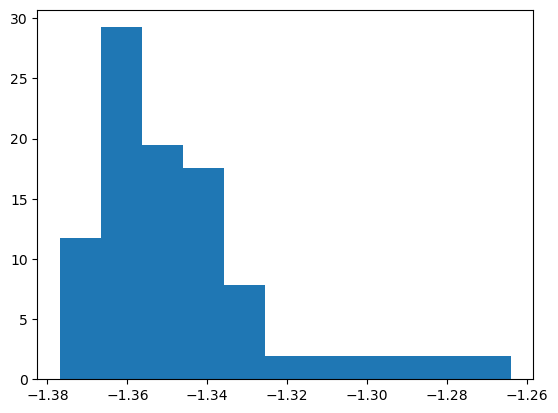

In [70]:
_ = plt.hist(np.log10(data), bins='fd', density=True)

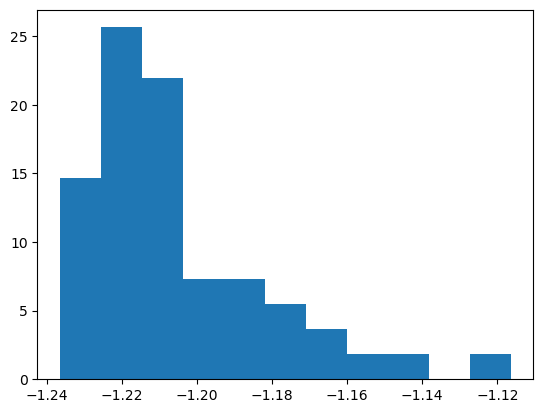

In [73]:
_ = plt.hist(np.log10(data), bins='fd', density=True)

### 3. Test LogTgaps Version
Just return number of paired obs in bins 

In [56]:
# metric + constraint
nbin = 20
mybins = np.logspace(0, np.log10(3650), nbin+1)
myweights = np.full(nbin, 1/nbin)
sfuncertdev = SFUncertMetricDev(mag=23.95, 
                                bins=mybins, weight=myweights, 
                                snr_cut=0)

# create bundle
sfmbdev = metricBundles.MetricBundle(sfuncertdev, slicer, constraint)

In [57]:
bdictdev = {0: sfmbdev}

In [62]:
run = 'ddf_season_length_slf0.35_v2.1_10yrs'
gpdev = metricBundles.MetricBundleGroup(bdictdev, opSimDbs[run], 
                                        outDir=outDir, 
                                        resultsDb=resultDbs[run])
gpdev.runAll()

Querying table None with constraint filter = "g" for columns ['fiveSigmaDepth', 'rotSkyPos', 'fieldDec', 'filter', 'observationStartMJD', 'fieldRA']
Found 229466 visits
Running:  [0]


/opt/conda/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [63]:
maskdev = sfmbdev.metricValues.mask
datadev = sfmbdev.metricValues.data[~maskdev]

In [64]:
nobs_md = np.median(np.vstack(datadev), axis=0)

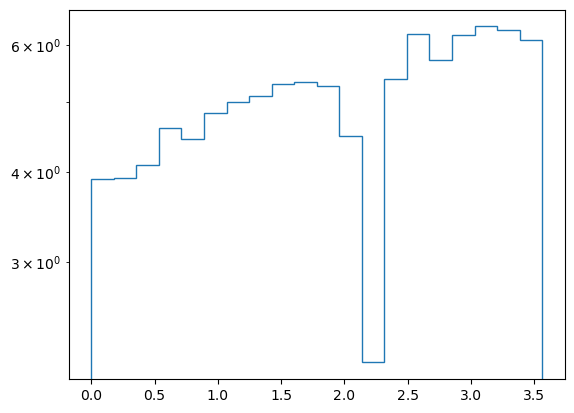

In [65]:
plt.stairs(np.log10(nobs_md), np.log10(mybins))
plt.xlabel('')
plt.yscale('log')

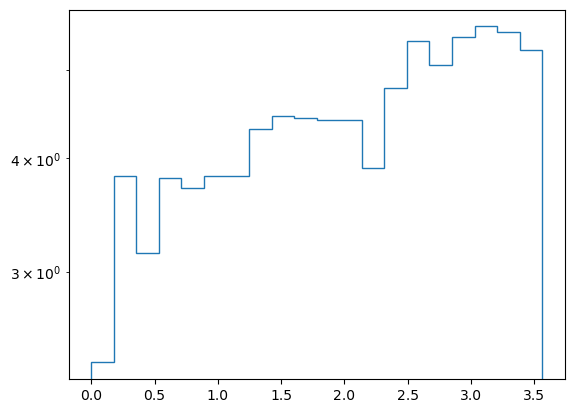

In [61]:
plt.stairs(np.log10(nobs_md), np.log10(mybins))
plt.xlabel('')
plt.yscale('log')

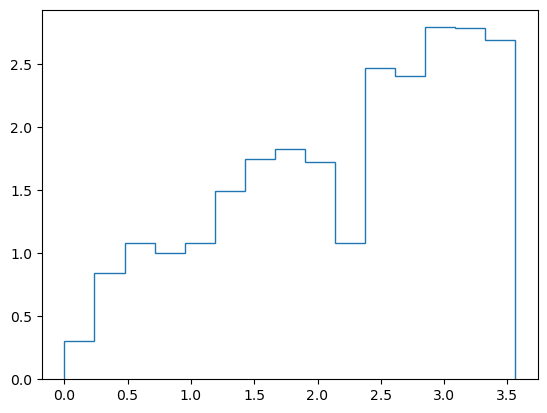

In [76]:
plt.stairs(np.log10(nobs_md), np.log10(mybins))

In [34]:
10**2.3

199.52623149688787